In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import random

TEMP_LOW_LIMIT = -20
TEMP_HIGH_LIMIT = 250

In [79]:
def exclude_temp_anml(df):
    result = df[(df['motor_temp'] > TEMP_LOW_LIMIT) & (df['motor_temp'] < TEMP_HIGH_LIMIT)]
    return result[(result['inlet_temp'] > TEMP_LOW_LIMIT) & (result['inlet_temp'] < TEMP_HIGH_LIMIT)]

In [80]:
def plot_feature_in_single_file(feature_name, unit, ylim_low=-20, ylim_high=3000, bins=20):
    file_df = pd.read_csv("../data/raw/train/unit{}_rms.csv".format(unit), index_col="timestamp")
    file_df = exclude_temp_anml(file_df)
    sns.set()
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    if ylim_low is None and ylim_high is None:
        file_df[feature_name].plot()
    else:
        file_df[feature_name].plot(ylim=(ylim_low, ylim_high))
    ax2 = fig.add_subplot(212)
    sns.distplot(file_df[feature_name], bins=bins)
    plt.show()

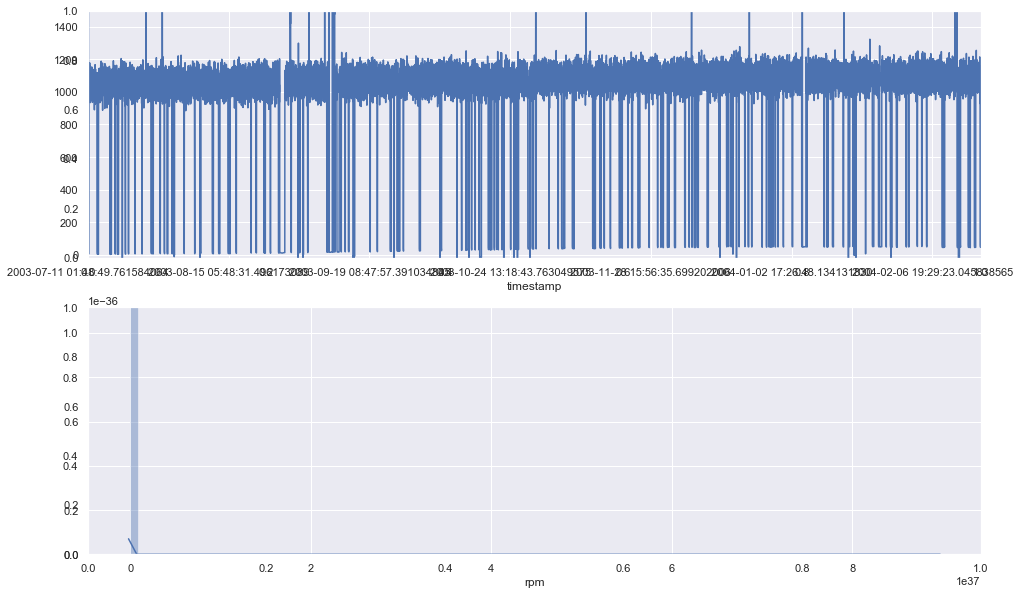

In [91]:
plot_feature_in_single_file("rpm", "0010", ylim_low=-20, ylim_high=1500, bins=100)

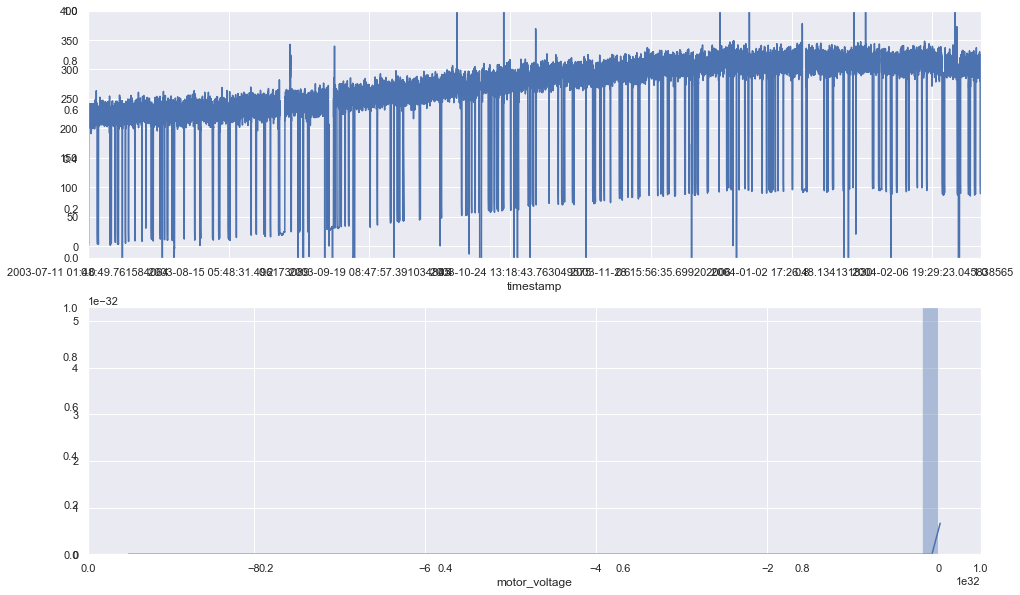

In [92]:
plot_feature_in_single_file("motor_voltage", "0010", ylim_high=400, bins=50)

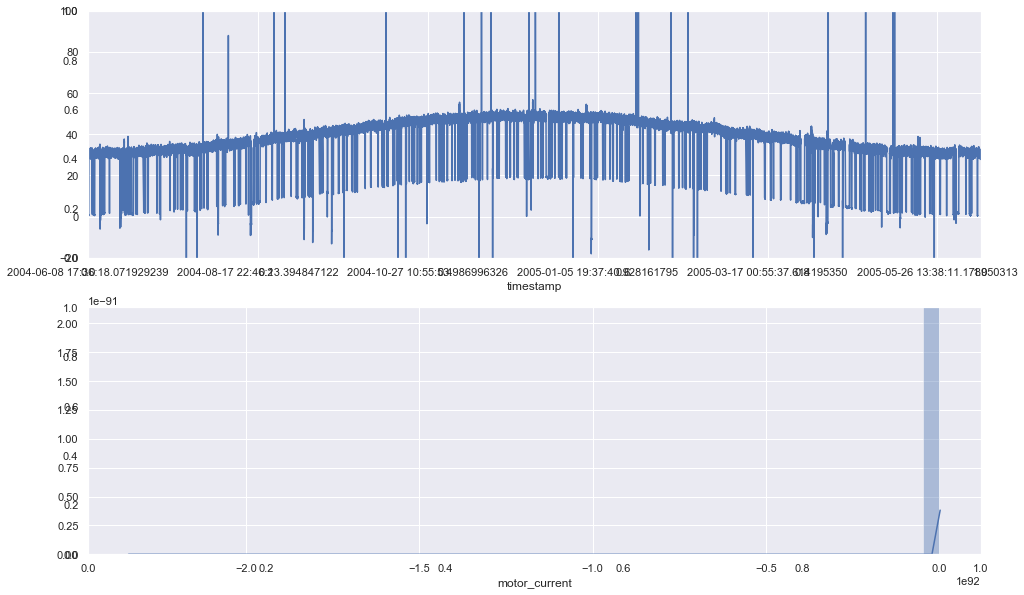

In [84]:
plot_feature_in_single_file("motor_current", "0017", ylim_low=-20, ylim_high=100, bins=50)

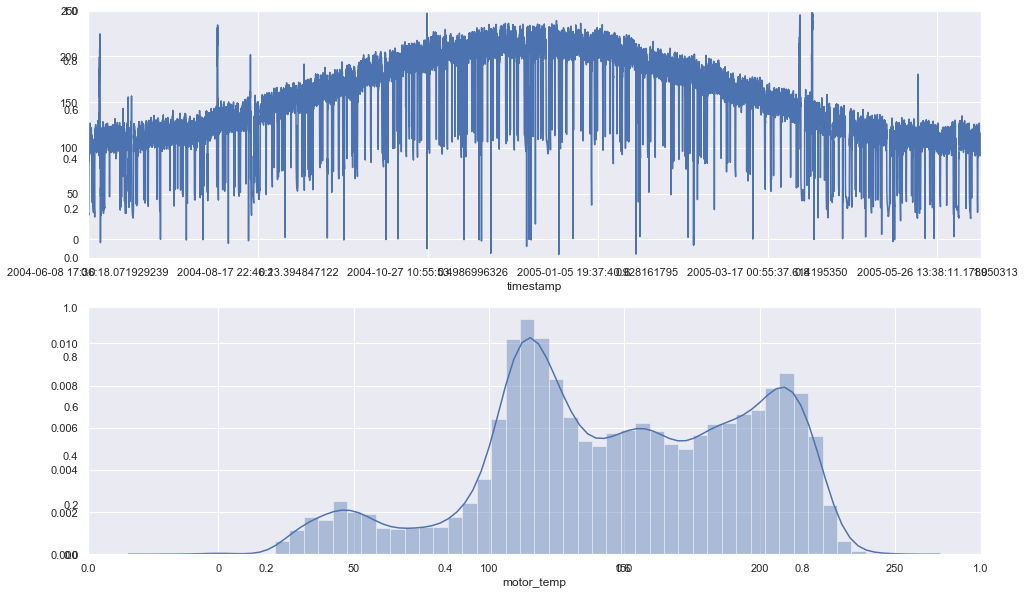

In [85]:
plot_feature_in_single_file("motor_temp", "0017", ylim_low=-20, ylim_high=250, bins=50)

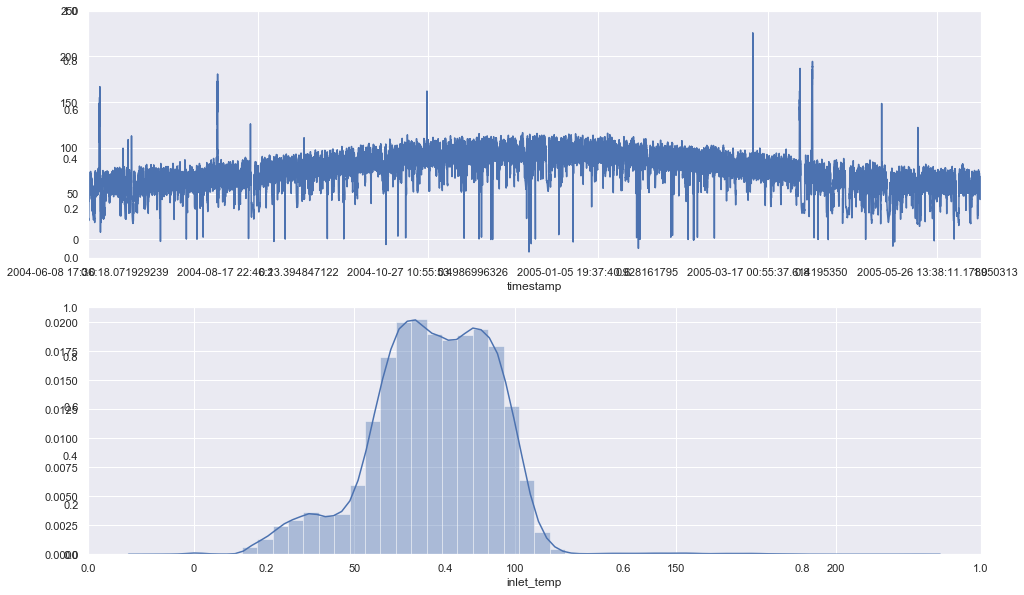

In [86]:
plot_feature_in_single_file("inlet_temp", "0017", ylim_low=-20, ylim_high=250, bins=50)

In [112]:
def peek_attributes_trend(attribute, ylim_low=-10, ylim_high=1500):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/raw/train/unit{}_rms.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, file_name in enumerate(file_names):
        file_df = pd.read_csv(file_name)
        file_df = exclude_temp_anml(file_df)
        ax1 = plt.subplot(3, 3, idx + 1)
        file_df[attribute].plot(ylim=(ylim_low, ylim_high))
    plt.show()

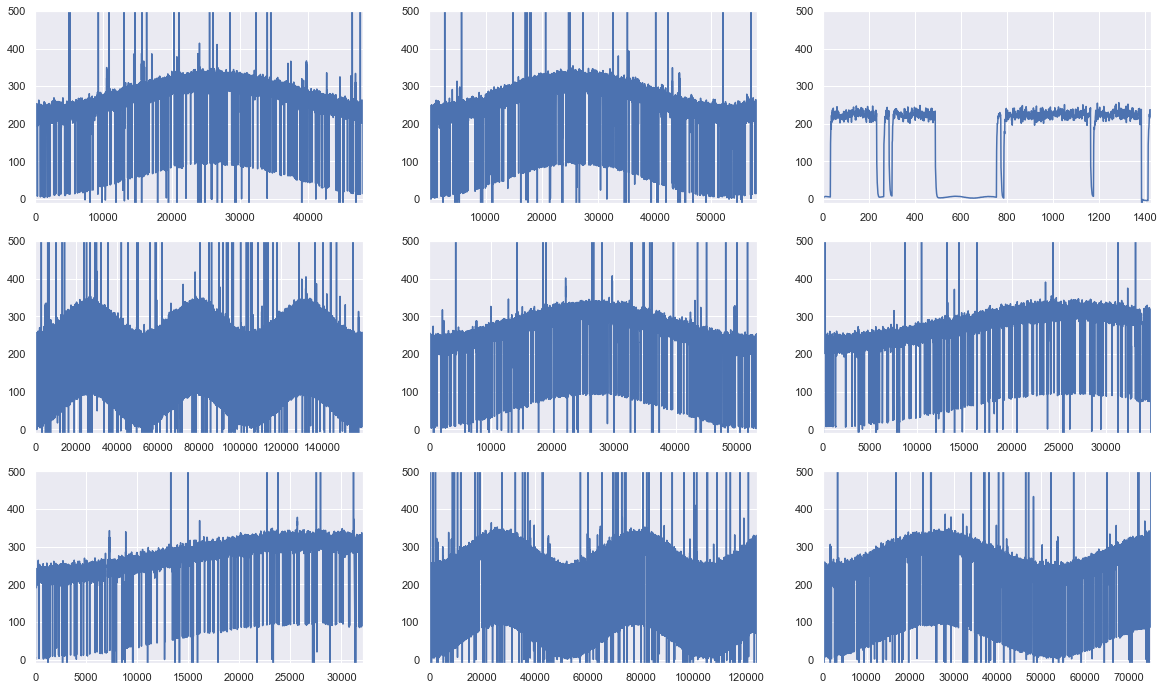

In [113]:
peek_attributes_trend('motor_voltage', ylim_high=500)

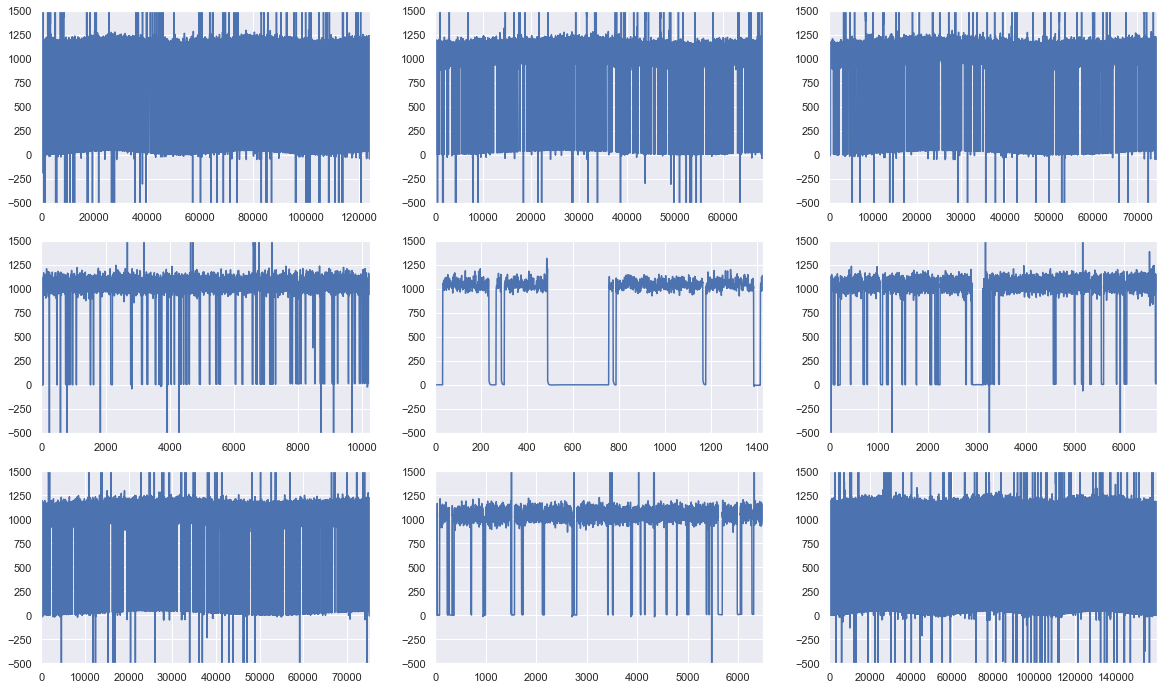

In [116]:
peek_attributes_trend('rpm', ylim_low=-500, ylim_high=1500)

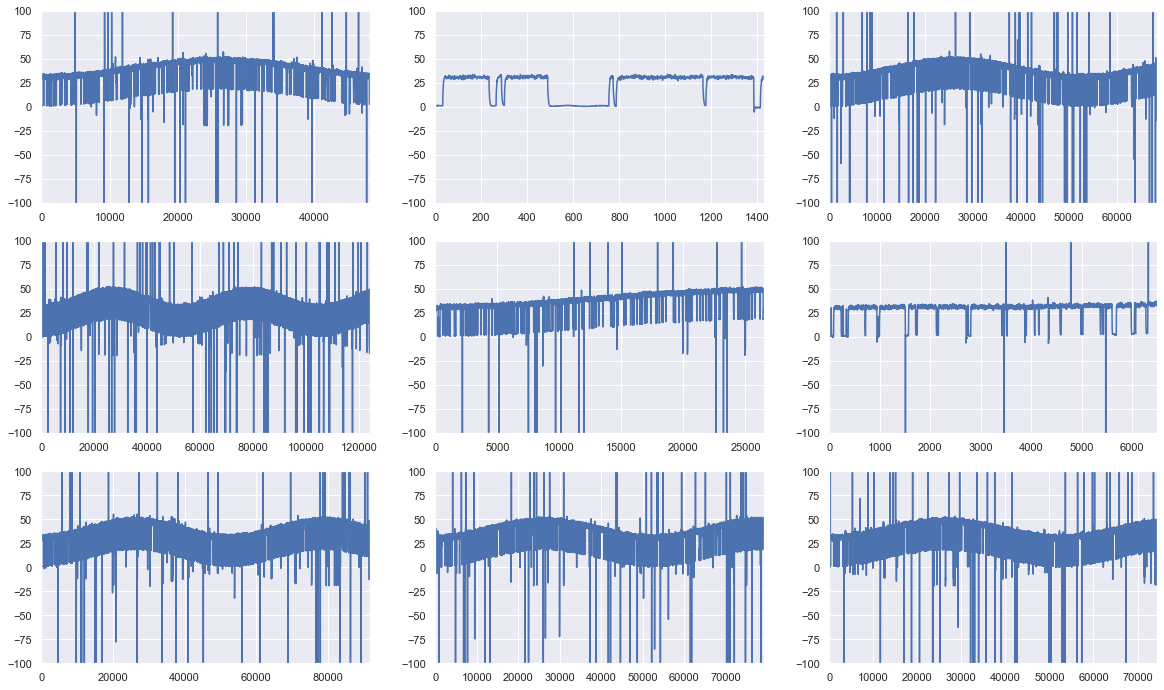

In [115]:
peek_attributes_trend('motor_current', ylim_low=-100, ylim_high=100)

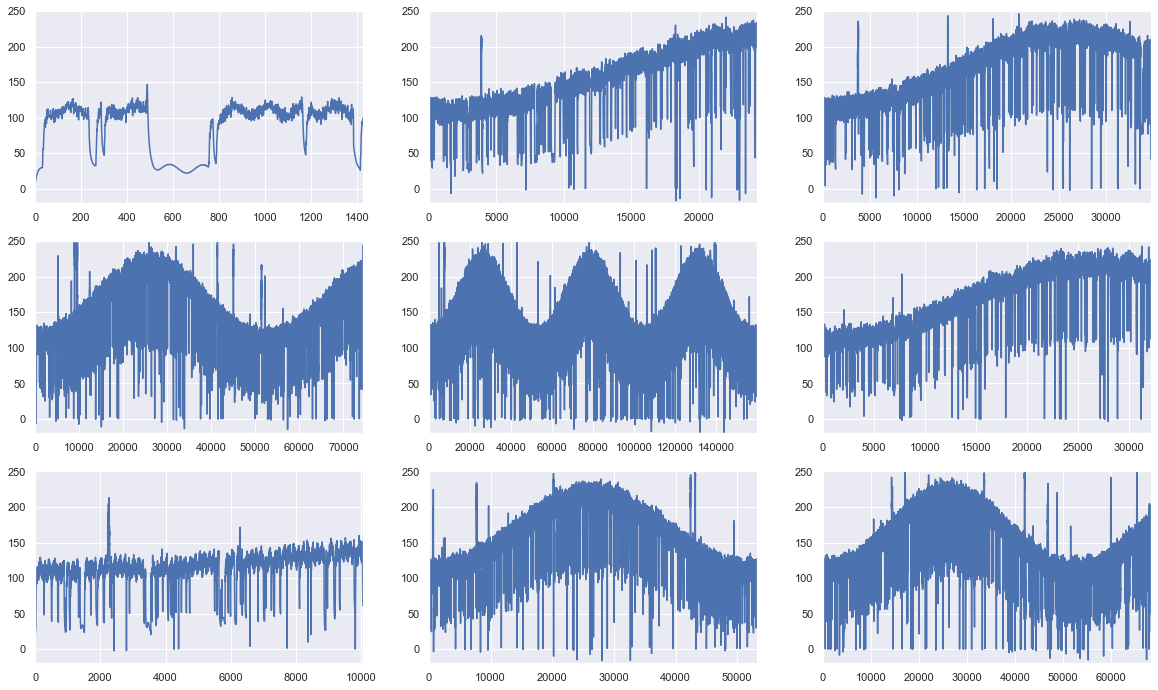

In [117]:
peek_attributes_trend('motor_temp', ylim_low=-20, ylim_high=250)

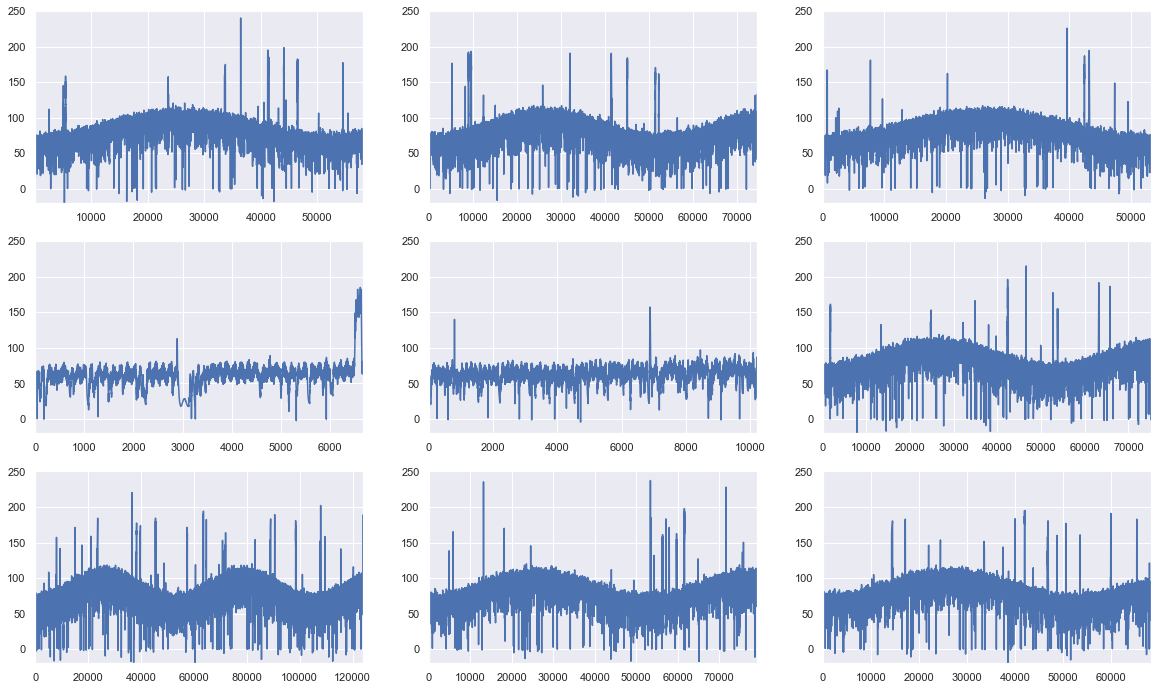

In [118]:
peek_attributes_trend('inlet_temp', ylim_low=-20, ylim_high=250)